/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0200 - val_loss: 1.8442e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.5239e-04 - val_loss: 7.2369e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.2074e-04 - val_loss: 5.2118e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.2819e-04 - val_loss: 1.6808e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.1082e-04 - val_loss: 2.1185e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 2.6738e-04 - val_loss: 5.4435e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.0406e-04 - val_loss: 2.6699e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.3386e-04 - val_loss: 1.5792e-04
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.3487e-04 - val_loss: 1.5980e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.4447e-04 - val_loss: 3.2862e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3

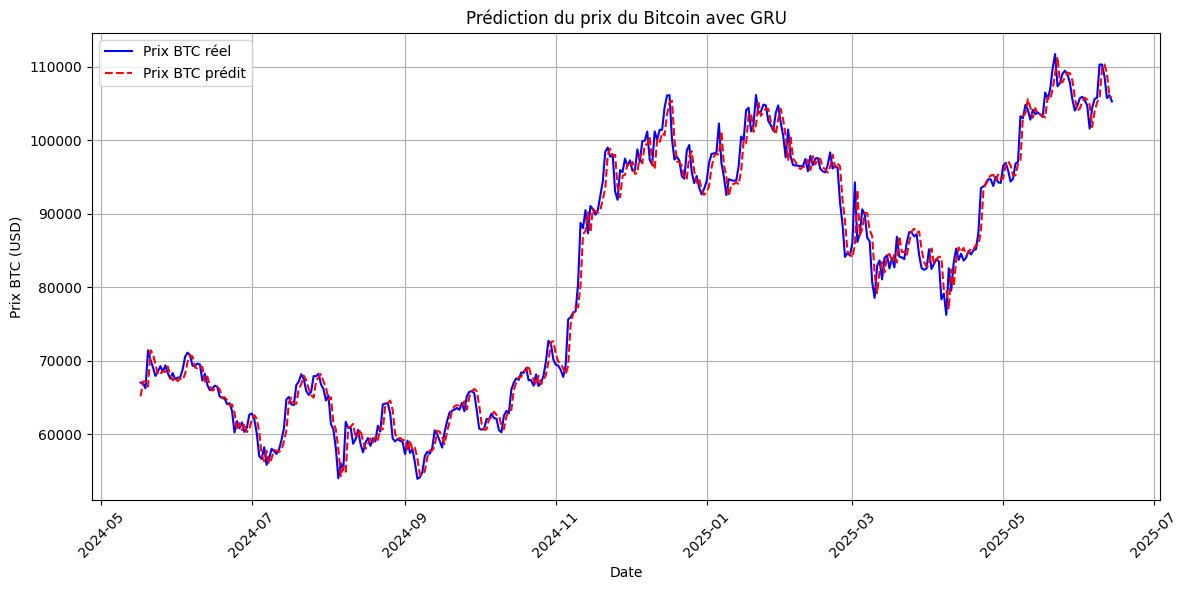

✅ Modèle sauvegardé sous le nom 'best_best_model.h5'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# ---------- 1. Collecte des données ----------
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la récupération des données : {response.status_code}")
        return None

# ---------- 2. Prétraitement ----------
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# ---------- 3. Création des séquences ----------
def create_sequences(eth_prices, btc_prices, seq_length):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# ---------- 4. Construction du modèle GRU ----------
def build_gru_model(seq_length, units=128, dropout=0.1, learning_rate=0.01):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(seq_length, 2)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ---------- 5. Entraînement et Évaluation ----------
def train_gru_model(data, seq_length=32, units=128, dropout=0.1, learning_rate=0.01):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_test_inv = btc_scaler.inverse_transform(y_test)
    y_pred_inv = btc_scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"\nÉvaluation finale du modèle GRU :")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv, label='Prix BTC réel', color='blue')
    plt.plot(test_dates, y_pred_inv, label='Prix BTC prédit', color='red', linestyle='--')
    plt.title('Prédiction du prix du Bitcoin avec GRU')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde
    model.save("best_best_model.h5")
    print("✅ Modèle sauvegardé sous le nom 'best_best_model.h5'")
    return model

# ---------- 6. Exécution ----------
if __name__ == "__main__":
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1 mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)
        model = train_gru_model(data)
    else:
        print("❌ Les données n'ont pas pu être récupérées.")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - loss: 0.1844 - val_loss: 0.0078
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - loss: 0.0030 - val_loss: 0.0067
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0027 - val_loss: 4.5031e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 8.1267e-04 - val_loss: 0.0012
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 7.5049e-04 - val_loss: 6.4541e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 8.9747e-04 - val_loss: 7.7790e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 6.8740e-04 - val_loss: 6.9103e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 7.6796e-04 - val_loss: 4.6269e-04
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 5.4286e-04 - val_loss: 7.6401e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 7.6944e-04 - val_loss: 3.6733e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 8.526

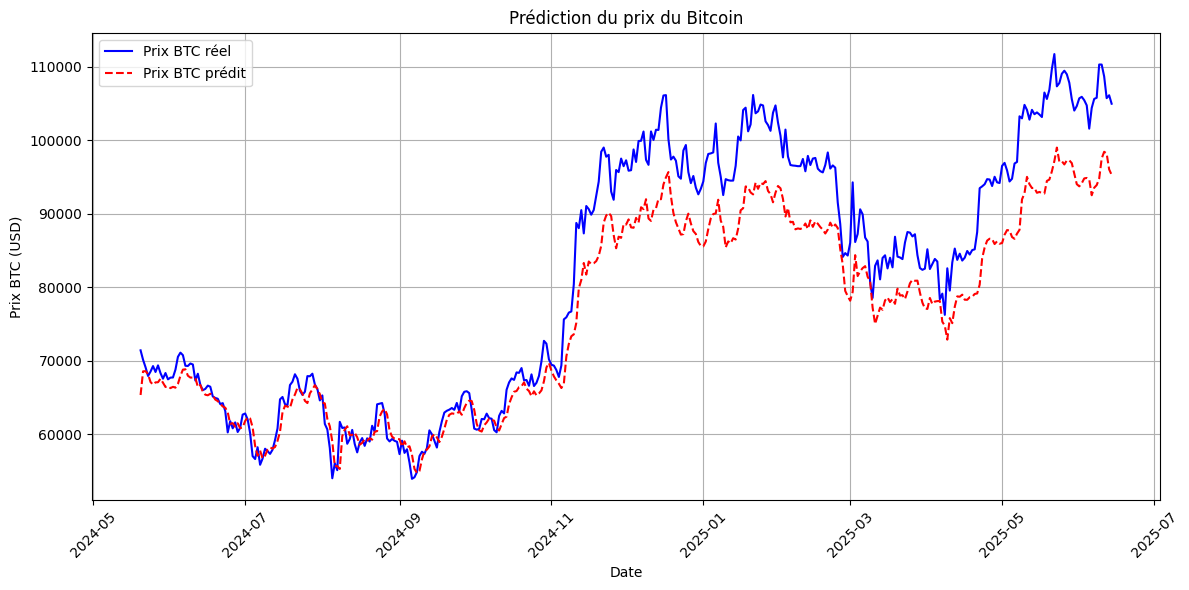

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# Fonction de récupération de données (inchangée)
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la récupération des données: {response.status_code}")
        return None

# Prétraitement
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# Création des séquences
def create_sequences(eth_prices, btc_prices, seq_length=30):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# Construction du modèle
def build_gru_model(seq_length, units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Entraînement avec les meilleurs paramètres
def train_best_gru_model_fixed(data):
    best_params = {
        'seq_length': 45,
        'units': 128,
        'dropout': 0.2,
        'learning_rate': 0.01
    }

    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, best_params['seq_length'])
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(
        best_params['seq_length'],
        best_params['units'],
        best_params['dropout'],
        best_params['learning_rate']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100, batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    gru_pred = model.predict(X_test)
    y_test_btc = btc_scaler.inverse_transform(y_test)
    gru_pred_btc = btc_scaler.inverse_transform(gru_pred)

    mse = mean_squared_error(y_test_btc, gru_pred_btc)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_btc, gru_pred_btc)

    print(f"\n✅ Évaluation finale du modèle :\nMSE : {mse:.2f}, RMSE : {rmse:.2f}, R² : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_btc, label='Prix BTC réel', color='blue')
    plt.plot(test_dates, gru_pred_btc, label='Prix BTC prédit', color='red', linestyle='--')
    plt.title('Prédiction du prix du Bitcoin')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde du modèle
    model.save("best_lstm_modele.h5")

    return model, eth_scaler, btc_scaler

# Utilisation
today = datetime.today()
end_timestamp = int(time.mktime(today.timetuple()))
start_timestamp = 1614556800  # 1er mars 2021

btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

if btc_data is not None and eth_data is not None:
    data = preprocess_data(btc_data, eth_data)
    model, eth_scaler, btc_scaler = train_best_gru_model_fixed(data)
else:
    print("❌ Erreur : Les données n'ont pas pu être récupérées.")


In [2]:
!pip install streamlit pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [3]:
!ngrok authtoken 2yJxbNZAJZUwdXCWrDdLb5lq3Gn_5UE56LbGwCADXG2fwrMyp

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
import time
from datetime import datetime, timedelta
import seaborn as sns
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration de la page
st.set_page_config(
    page_title="📈 ETH-to-BTC",
    page_icon="₿",
    layout="wide",
    initial_sidebar_state="expanded"
)

# CSS pour le style
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        font-weight: bold;
        text-align: center;
        background: linear-gradient(90deg, #f7931e, #4CAF50);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        margin-bottom: 2rem;
    }
    .metric-card {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin: 0.5rem 0;
    }
    .prediction-card {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        padding: 1.5rem;
        border-radius: 15px;
        color: white;
        margin: 1rem 0;
    }
.news-card {
    background: #cce5ff; /* bleu clair */
    color: #000;          /* texte noir */
    padding: 1rem;
    border-radius: 8px;
    border-left: 4px solid #007bff;
    margin: 0.5rem 0;
}



</style>
""", unsafe_allow_html=True)

# Titre principal
st.markdown('<h1 class="main-header">₿ Bitcoin Prediction Dashboard</h1>', unsafe_allow_html=True)

# Fonctions utilitaires
@st.cache_data(ttl=300)  # Cache pendant 5 minutes
def get_crypto_data(symbol, limit=100):
    """Récupérer les données crypto depuis CryptoCompare"""
    try:
        url = f'https://min-api.cryptocompare.com/data/v2/histoday'
        params = {
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'extraParams': 'streamlit_app'
        }
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()['Data']['Data']
            df = pd.DataFrame(data)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            return df
        else:
            st.error(f"Erreur API: {response.status_code}")
            return None
    except Exception as e:
        st.error(f"Erreur lors de la récupération des données: {e}")
        return None

@st.cache_data(ttl=1800)  # Cache pendant 30 minutes
def get_crypto_news():
    """Récupérer les actualités crypto"""
    try:
        url = 'https://min-api.cryptocompare.com/data/v2/news/'
        params = {
            'lang': 'EN',
            'sortOrder': 'latest',
            'limit': 10
        }
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()['Data']
        else:
            return []
    except Exception as e:
        st.error(f"Erreur lors de la récupération des actualités: {e}")
        return []

def calculate_correlation(btc_data, eth_data, window=30):
    """Calculer la corrélation glissante"""
    btc_prices = btc_data.set_index('time')['close']
    eth_prices = eth_data.set_index('time')['close']

    # Aligner les données
    common_dates = btc_prices.index.intersection(eth_prices.index)
    btc_aligned = btc_prices.loc[common_dates]
    eth_aligned = eth_prices.loc[common_dates]

    # Corrélation glissante
    correlation = btc_aligned.rolling(window=window).corr(eth_aligned)
    return correlation

def create_sequences_for_prediction(eth_prices, btc_prices, seq_length):
    """Créer des séquences pour la prédiction"""
    if len(eth_prices) < seq_length or len(btc_prices) < seq_length:
        return None

    # Prendre les dernières séquences
    eth_seq = eth_prices[-seq_length:]
    btc_seq = btc_prices[-seq_length:]

    return np.column_stack((eth_seq, btc_seq)).reshape(1, seq_length, 2)

# Sidebar pour la navigation
st.sidebar.title("🔍 Navigation")
section = st.sidebar.selectbox(
    "Choisir une section:",
    ["📊 Prix des Cryptomonnaies", "📈 Statistiques & Corrélation", "📰 Actualités Finance", "🔮 Prédictions Bitcoin"]
)

# Section 1: Prix des Cryptomonnaies
if section == "📊 Prix des Cryptomonnaies":
    st.header("📊 Prix des Cryptomonnaies en Temps Réel")

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("₿ Bitcoin (BTC)")
        btc_data = get_crypto_data('BTC')
        if btc_data is not None:
            current_btc = btc_data.iloc[-1]
            prev_btc = btc_data.iloc[-2]
            change_btc = ((current_btc['close'] - prev_btc['close']) / prev_btc['close']) * 100

            st.metric(
                label="Prix Actuel (USD)",
                value=f"${current_btc['close']:,.2f}",
                delta=f"{change_btc:+.2f}%"
            )

            # Tableau des données récentes
            st.subheader("📋 Données Récentes BTC")
            display_data = btc_data.tail(10)[['time', 'close', 'high', 'low', 'volumeto']].copy()
            display_data['time'] = display_data['time'].dt.strftime('%Y-%m-%d')
            display_data.columns = ['Date', 'Clôture', 'Haut', 'Bas', 'Volume']
            st.dataframe(display_data, use_container_width=True)

    with col2:
        st.subheader("⟠ Ethereum (ETH)")
        eth_data = get_crypto_data('ETH')
        if eth_data is not None:
            current_eth = eth_data.iloc[-1]
            prev_eth = eth_data.iloc[-2]
            change_eth = ((current_eth['close'] - prev_eth['close']) / prev_eth['close']) * 100

            st.metric(
                label="Prix Actuel (USD)",
                value=f"${current_eth['close']:,.2f}",
                delta=f"{change_eth:+.2f}%"
            )

            # Tableau des données récentes
            st.subheader("📋 Données Récentes ETH")
            display_data = eth_data.tail(10)[['time', 'close', 'high', 'low', 'volumeto']].copy()
            display_data['time'] = display_data['time'].dt.strftime('%Y-%m-%d')
            display_data.columns = ['Date', 'Clôture', 'Haut', 'Bas', 'Volume']
            st.dataframe(display_data, use_container_width=True)

    # Graphiques individuels BTC et ETH côte à côte
    st.subheader("📈 Évolution des Prix")
    if btc_data is not None and eth_data is not None:
        col1_chart, col2_chart = st.columns(2)

        with col1_chart:
            # Graphique BTC individuel
            fig_btc = go.Figure()
            fig_btc.add_trace(go.Scatter(
                x=btc_data['time'],
                y=btc_data['close'],
                mode='lines',
                name='Prix BTC',
                line=dict(color='#f7931e', width=2)
            ))
            fig_btc.update_layout(
                title="Bitcoin (BTC)",
                xaxis_title="Date",
                yaxis_title="Prix (USD)",
                template="plotly_white",
                height=400
            )
            st.plotly_chart(fig_btc, use_container_width=True)

        with col2_chart:
            # Graphique ETH individuel
            fig_eth = go.Figure()
            fig_eth.add_trace(go.Scatter(
                x=eth_data['time'],
                y=eth_data['close'],
                mode='lines',
                name='Prix ETH',
                line=dict(color='#4CAF50', width=2)
            ))
            fig_eth.update_layout(
                title="Ethereum (ETH)",
                xaxis_title="Date",
                yaxis_title="Prix (USD)",
                template="plotly_white",
                height=400
            )
            st.plotly_chart(fig_eth, use_container_width=True)

        # Graphique combiné sur le même axe
        st.subheader("📊 Comparaison BTC vs ETH - Prix dans le même graphique")
        fig_combined = go.Figure()

        # BTC trace
        fig_combined.add_trace(go.Scatter(
            x=btc_data['time'],
            y=btc_data['close'],
            mode='lines',
            name='Bitcoin (BTC)',
            line=dict(color='#f7931e', width=2)
        ))

        # ETH trace
        fig_combined.add_trace(go.Scatter(
            x=eth_data['time'],
            y=eth_data['close'],
            mode='lines',
            name='Ethereum (ETH)',
            line=dict(color='#4CAF50', width=2)
        ))

        fig_combined.update_layout(
            title="Évolution des Prix BTC vs ETH (30 derniers jours)",
            xaxis_title="Date",
            yaxis_title="Prix (USD)",
            template="plotly_white",
            height=500,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        st.plotly_chart(fig_combined, use_container_width=True)

    # Section des autres cryptomonnaies
    st.subheader("💰 Autres Cryptomonnaies Populaires")

    # Liste des autres cryptos à afficher
    other_cryptos = [
        ('ADA', 'Cardano', '🔵'),
        ('DOT', 'Polkadot', '🔴'),
        ('LINK', 'Chainlink', '🔗'),
        ('XRP', 'Ripple', '💧'),
        ('LTC', 'Litecoin', '⚡'),
        ('BCH', 'Bitcoin Cash', '💚'),
        ('UNI', 'Uniswap', '🦄'),
        ('MATIC', 'Polygon', '🟣')
    ]

    # Créer des colonnes pour afficher les prix
    cols = st.columns(4)

    for idx, (symbol, name, emoji) in enumerate(other_cryptos):
        with cols[idx % 4]:
            crypto_data = get_crypto_data(symbol)
            if crypto_data is not None:
                current_price = crypto_data.iloc[-1]['close']
                prev_price = crypto_data.iloc[-2]['close']
                change = ((current_price - prev_price) / prev_price) * 100

                # Couleur selon la variation
                delta_color = "normal"
                if change > 0:
                    delta_color = "normal"
                elif change < 0:
                    delta_color = "inverse"

                st.metric(
                    label=f"{emoji} {name} ({symbol})",
                    value=f"${current_price:.4f}" if current_price < 1 else f"${current_price:,.2f}",
                    delta=f"{change:+.2f}%"
                )
            else:
                st.error(f"Erreur: Impossible de charger {name}")

    # Tableau récapitulatif
    st.subheader("📊 Tableau Récapitulatif")

    summary_data = []
    all_cryptos = [('BTC', 'Bitcoin')] + [('ETH', 'Ethereum')] + [(symbol, name) for symbol, name, _ in other_cryptos]

    for symbol, name in all_cryptos:
        crypto_data = get_crypto_data(symbol)
        if crypto_data is not None:
            current = crypto_data.iloc[-1]
            prev = crypto_data.iloc[-2]
            change = ((current['close'] - prev['close']) / prev['close']) * 100

            summary_data.append({
                'Cryptomonnaie': f"{name} ({symbol})",
                'Prix Actuel (USD)': f"${current['close']:,.4f}" if current['close'] < 1 else f"${current['close']:,.2f}",
                'Variation 24h (%)': f"{change:+.2f}%",
                'Volume 24h': f"${current['volumeto']:,.0f}",
                'Plus Haut 24h': f"${current['high']:,.4f}" if current['high'] < 1 else f"${current['high']:,.2f}",
                'Plus Bas 24h': f"${current['low']:,.4f}" if current['low'] < 1 else f"${current['low']:,.2f}"
            })

    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        st.dataframe(summary_df, use_container_width=True)
# Section 2: Statistiques & Corrélation
elif section == "📈 Statistiques & Corrélation":
    st.header("📈 Statistiques & Analyse de Corrélation")

    # Récupérer plus de données pour l'analyse
    btc_data = get_crypto_data('BTC', 365)
    eth_data = get_crypto_data('ETH', 365)

    if btc_data is not None and eth_data is not None:
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("📊 Statistiques Bitcoin")
            btc_stats = {
                'Prix Moyen': f"${btc_data['close'].mean():,.2f}",
                'Prix Médian': f"${btc_data['close'].median():,.2f}",
                'Écart-type': f"${btc_data['close'].std():,.2f}",
                'Volatilité (CV)': f"{(btc_data['close'].std()/btc_data['close'].mean()*100):.2f}%",
                'Prix Min': f"${btc_data['close'].min():,.2f}",
                'Prix Max': f"${btc_data['close'].max():,.2f}"
            }

            for key, value in btc_stats.items():
                st.metric(key, value)

        with col2:
            st.subheader("📊 Statistiques Ethereum")
            eth_stats = {
                'Prix Moyen': f"${eth_data['close'].mean():,.2f}",
                'Prix Médian': f"${eth_data['close'].median():,.2f}",
                'Écart-type': f"${eth_data['close'].std():,.2f}",
                'Volatilité (CV)': f"{(eth_data['close'].std()/eth_data['close'].mean()*100):.2f}%",
                'Prix Min': f"${eth_data['close'].min():,.2f}",
                'Prix Max': f"${eth_data['close'].max():,.2f}"
            }

            for key, value in eth_stats.items():
                st.metric(key, value)

        # Corrélation glissante
        st.subheader("🔗 Corrélation Glissante BTC-ETH")
        correlation_window = st.slider("Fenêtre de corrélation (jours)", 7, 90, 30)
        correlation = calculate_correlation(btc_data, eth_data, correlation_window)

        fig_corr = go.Figure()
        fig_corr.add_trace(go.Scatter(
            x=correlation.index,
            y=correlation.values,
            mode='lines',
            name=f'Corrélation ({correlation_window} jours)',
            line=dict(color='purple', width=2)
        ))
        fig_corr.add_hline(y=0.5, line_dash="dash", line_color="red",
                          annotation_text="Corrélation forte (0.5)")
        fig_corr.update_layout(
            title=f"Corrélation Glissante BTC-ETH ({correlation_window} jours)",
            xaxis_title="Date",
            yaxis_title="Coefficient de Corrélation",
            template="plotly_white",
            height=400
        )
        st.plotly_chart(fig_corr, use_container_width=True)

# Section 3: Actualités Finance
elif section == "📰 Actualités Finance":
    st.header("📰 Actualités Financières & Crypto")

    news_data = get_crypto_news()

    if news_data:
        for i, article in enumerate(news_data):
            with st.container():
                st.markdown(f"""
                <div class="news-card">
                    <h4>{article.get('title', 'Titre non disponible')}</h4>
                    <p><strong>Source:</strong> {article.get('source_info', {}).get('name', 'Source inconnue')}</p>
                    <p>{article.get('body', 'Contenu non disponible')[:300]}...</p>
                    <p><small>📅 {datetime.fromtimestamp(article.get('published_on', 0)).strftime('%Y-%m-%d %H:%M')}</small></p>
                </div>
                """, unsafe_allow_html=True)

                if article.get('url'):
                    st.markdown(f"[📖 Lire l'article complet]({article['url']})")

                st.divider()
    else:
        st.warning("Aucune actualité disponible pour le moment.")

# Section 5: Prédictions Bitcoin
elif section == "🔮 Prédictions Bitcoin":
    st.header("🔮 Prédictions Bitcoin avec IA")

    # Paramètres de prédiction
    col1, col2 = st.columns([1, 2])

    with col1:
        st.subheader("⚙️ Paramètres de Prédiction")

        model_choice = st.selectbox(
            "Choisir le modèle:",
            ["best_best_model.h5", "best_lstm_model.h5", "Modèle 3 (À venir)"]
        )

        days_to_predict = st.slider(
            "Nombre de jours à prédire:",
            min_value=1,
            max_value=30,
            value=7
        )

        risk_tolerance = st.selectbox(
            "Tolérance au risque:",
            ["Conservateur", "Modéré", "Agressif"]
        )

        confidence_threshold = st.slider(
            "Seuil de confiance (%):",
            min_value=50,
            max_value=95,
            value=80
        )

    with col2:
        st.subheader("📊 Résultats de Prédiction")

        if st.button("🚀 Générer Prédiction", type="primary"):
            try:
                # Charger le modèle
                if model_choice == "best_best_model.h5":
                    try:
                        model = load_model("best_best_model.h5", compile=False)
                        model.compile(optimizer='adam', loss='mse')
                        st.success("✅ Modèle best_best_model.h5 chargé avec succès!")
                    except:
                        st.error("❌ Impossible de charger le modèle best_best_model.h5. Vérifiez que le fichier existe.")
                        st.stop()
                elif model_choice == "best_lstm_model.h5":
                    try:
                        model = load_model("best_lstm_modele.h5", compile=False)
                        model.compile(optimizer='adam', loss='mse')
                        st.success("✅ Modèle best_lstm_model.h5 chargé avec succès!")
                    except:
                        st.error("❌ Impossible de charger le modèle best_lstm_model.h5. Vérifiez que le fichier existe.")
                        st.stop()
                else:
                    st.warning("⚠️ Le troisième modèle n'est pas encore disponible.")
                    st.stop()

                # Récupérer les données récentes
                btc_data = get_crypto_data('BTC', 100)
                eth_data = get_crypto_data('ETH', 100)

                if btc_data is not None and eth_data is not None:
                    eth_scaler = MinMaxScaler()
                    btc_scaler = MinMaxScaler()

                    eth_scaled = eth_scaler.fit_transform(eth_data[['close']])
                    btc_scaled = btc_scaler.fit_transform(btc_data[['close']])

                    seq_length = 32
                    if len(eth_scaled) >= seq_length and len(btc_scaled) >= seq_length:
                        sequence = create_sequences_for_prediction(
                            eth_scaled.flatten(),
                            btc_scaled.flatten(),
                            seq_length
                        )

                        if sequence is not None:
                            predictions = []
                            current_btc = btc_data['close'].iloc[-1]

                            for day in range(days_to_predict):
                                pred_scaled = model.predict(sequence, verbose=0)
                                pred_price = btc_scaler.inverse_transform(pred_scaled)[0][0]
                                predictions.append(pred_price)

                                new_eth = eth_scaled[-1]
                                new_btc = pred_scaled[0]

                                sequence = np.roll(sequence, -1, axis=1)
                                sequence[0, -1, 0] = new_eth
                                sequence[0, -1, 1] = new_btc

                            last_date = btc_data['time'].iloc[-1]
                            future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]

                            # Afficher le nom du modèle utilisé
                            model_name = model_choice.replace('.h5', '').replace('_', ' ').title()

                            st.markdown(f"""
                            <div class="prediction-card">
                                <h3>🔮 Prédictions pour les {days_to_predict} prochains jours</h3>
                                <p><strong>Modèle utilisé:</strong> {model_name}</p>
                                <p><strong>Prix actuel BTC:</strong> ${current_btc:,.2f}</p>
                                <p><strong>Prix prédit (J+{days_to_predict}):</strong> ${predictions[-1]:,.2f}</p>
                                <p><strong>Variation prévue:</strong> {((predictions[-1] - current_btc) / current_btc * 100):+.2f}%</p>
                            </div>
                            """, unsafe_allow_html=True)

                            fig_pred = go.Figure()
                            fig_pred.add_trace(go.Scatter(
                                x=btc_data['time'].tail(30),
                                y=btc_data['close'].tail(30),
                                mode='lines',
                                name='Prix Historique',
                                line=dict(color='blue')
                            ))
                            fig_pred.add_trace(go.Scatter(
                                x=future_dates,
                                y=predictions,
                                mode='lines+markers',
                                name=f'Prédictions ({model_name})',
                                line=dict(color='red', dash='dash'),
                                marker=dict(size=8)
                            ))
                            fig_pred.update_layout(
                                title=f"Prédiction Bitcoin - {days_to_predict} jours ({model_name})",
                                xaxis_title="Date",
                                yaxis_title="Prix (USD)",
                                template="plotly_white",
                                height=500
                            )
                            st.plotly_chart(fig_pred, use_container_width=True)

                            st.subheader("💡 Recommandations")

                            change_pct = (predictions[-1] - current_btc) / current_btc * 100

                            if change_pct > 5:
                                recommendation = "🟢 ACHETER"
                                reason = "Tendance haussière forte prévue"
                                risk_level = "Faible" if risk_tolerance == "Agressif" else "Modéré"
                            elif change_pct > 2:
                                recommendation = "🟡 ACHETER (Prudent)"
                                reason = "Tendance haussière modérée"
                                risk_level = "Modéré"
                            elif change_pct > -2:
                                recommendation = "⚪ HOLD"
                                reason = "Mouvement latéral prévu"
                                risk_level = "Faible"
                            elif change_pct > -5:
                                recommendation = "🟠 VENDRE (Partiel)"
                                reason = "Tendance baissière modérée"
                                risk_level = "Modéré"
                            else:
                                recommendation = "🔴 VENDRE"
                                reason = "Tendance baissière forte"
                                risk_level = "Élevé"

                            col3, col4 = st.columns(2)
                            with col3:
                                st.metric("Recommandation", recommendation)
                                st.metric("Raison", reason)

                            with col4:
                                st.metric("Niveau de Risque", risk_level)
                                st.metric("Confiance", f"{confidence_threshold}%")

                            st.subheader("📋 Prédictions Détaillées")
                            pred_df = pd.DataFrame({
                                'Date': [date.strftime('%Y-%m-%d') for date in future_dates],
                                'Prix Prédit (USD)': [f"${price:,.2f}" for price in predictions],
                                'Variation (%)': [f"{((price - current_btc) / current_btc * 100):+.2f}%" for price in predictions]
                            })
                            st.dataframe(pred_df, use_container_width=True)

                        else:
                            st.error("❌ Impossible de créer la séquence de prédiction.")
                    else:
                        st.error("❌ Pas assez de données pour faire une prédiction.")
                else:
                    st.error("❌ Impossible de récupérer les données nécessaires.")

            except Exception as e:
                st.error(f"❌ Erreur lors de la génération des prédictions: {e}")

        st.warning("""
        ⚠️ **Avertissement Important:**

        Ces prédictions sont générées par un modèle d'IA et ne constituent pas des conseils financiers.
        Les marchés des cryptomonnaies sont extrêmement volatils et imprévisibles.
        Investissez toujours de manière responsable et ne risquez que ce que vous pouvez vous permettre de perdre.
        """)

# Footer
st.markdown("---")
st.markdown(
    """
    <div style="text-align: center; color: #666;">
        <p>💡 Développé avec Streamlit | Données via CryptoCompare API</p>
        <p>⚠️ Cette application est à des fins éducatives uniquement</p>
    </div>
    """,
    unsafe_allow_html=True
)

Overwriting app.py


In [18]:
from pyngrok import ngrok

# Ouvre un tunnel vers http://localhost:8501
public_url = ngrok.connect(8501)
print("🚀 L'application est disponible ici :", public_url)

# Démarre Streamlit en arrière-plan
!streamlit run app.py &



🚀 L'application est disponible ici : NgrokTunnel: "https://3c03-34-83-60-198.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.60.198:8501

2025-06-14 08:24:44.984443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749889485.052686   29617 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749889485.066903   29617 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 08:25:02.897344: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Fai

  Stopping...
